In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import shutil
import random
PROJ_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(PROJ_DIR, "src"))

from pkg.utils.utils_python3 import *
DATA_PATH = os.path.join(PROJ_DIR, "data")
LAT_DATA_PATH = os.path.join(DATA_PATH, "latticized")
MODEL_PATH = os.path.join(PROJ_DIR, "model")
LAT_MODEL_PATH = os.path.join(MODEL_PATH,"latticized")
try_mkdir(MODEL_PATH)
try_mkdir(LAT_MODEL_PATH)
GRASP_FOLDER = "grasp"
ARM10_FOLDER = "arm_10"
ARM05_FOLDER = "arm_05"
FULLS_FOLDER = "full_scene"

In [3]:
ROBOT_TYPE_NAME="indy7"
ROBOT_DATA_ROOT = os.path.join(LAT_DATA_PATH, ROBOT_TYPE_NAME)
# ROBOT_DATA_ROOT = LAT_DATA_PATH
ROBOT_MODEL_ROOT =  os.path.join(LAT_MODEL_PATH, ROBOT_TYPE_NAME)
ARM_FOLDER = ARM10_FOLDER

In [4]:
dataset_list = sorted(os.listdir(ROBOT_DATA_ROOT))
DATASET_TRAIN = dataset_list[:10]
DATASET_TEST = dataset_list[10:15]
print(DATASET_TRAIN)
print(DATASET_TEST)

['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319', '20210216-005455', '20210216-054418', '20210216-104554', '20210216-152114', '20210216-201729']
['20210217-010926', '20210217-063641', '20210217-113319', '20210217-162106', '20210217-205606']


In [5]:
# DATASET_TRAIN = ['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319', 
#                  '20210216-005455', '20210216-054418', '20210216-104554', '20210216-152114', '20210216-201729']
# DATASET_TEST = ['20210217-010926', '20210217-063641', '20210217-113319', '20210217-162106', '20210217-205606']
# DATASET_TRAIN = ['20210219-091338', '20210219-124428', '20210219-234147', '20210220-035639', '20210220-080119', 
#                  '20210220-122304', '20210220-160737', '20210220-194129', '20210220-234400', '20210221-043209']
# DATASET_TEST = ['20210221-082144', '20210221-123619', '20210221-160542', '20210221-195509', '20210221-234239']
GRASP_SHAPE = (20,20,20)
ARM_SHAPE = (20,20,20)
RH_MASK_SIZE = 512
RH_MASK_STEP = 64

data_pairs_train = []
for dataset in DATASET_TRAIN:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
print("train set: {}".format(len(data_pairs_train)))        
        
        
data_pairs_test = []
for dataset in DATASET_TEST:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
print("train set: {}".format(len(data_pairs_test)))        

train set: 10022
train set: 5002


In [6]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def div_r_gaussian(r_val):
    return gaussian(r_val, np.arange(0.1,1.2, 0.05),0.1)

def div_h_gaussian(h_val):
    return gaussian(h_val, np.arange(-0.5,1.1, 0.05),0.1)

def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_mask = div_r_gaussian(r_ej)
    h_mask = div_h_gaussian(h_ej)
    rh_mask = np.concatenate([r_mask, h_mask])
#     rh_mask = np.array([r, h, r_ej, h_ej])
    # r_ej_list.append(r_ej)
    # h_ej_list.append(h_ej)
    # reach_lb_list.append(reach_lb)
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
#     grasp_img = np.stack([grasp_tool_img, np.logical_or(grasp_obj_img, grasp_tar_img)], axis=-1)
#     grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label

## Train

In [7]:
from pkg.planning.filtering.lattice_model.lattice_model import *

# Create an instance of the model
model = ResNetModelTP()

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [8]:
current_time = get_now()
logpath = os.path.join(ROBOT_MODEL_ROOT, current_time)
try_mkdir(logpath)
train_log_dir = os.path.join(logpath, 'train')
test_log_dir = os.path.join(logpath, 'test')
model_log_dir = os.path.join(logpath, 'model_{}/')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
shutil.copy(os.path.join(PROJ_DIR,'src', 'pkg','planning','filtering','lattice_model','lattice_model.py' ), logpath)
print(f'Log path: {logpath}')

Log path: /home/rnb/Projects/rnb-planning/model/latticized/indy7/20210222-153704


In [9]:
EPOCHS_S = 0
EPOCHS_E = 15
BATCH_SIZE = 16
LOG_STEP = 100
N_train = len(data_pairs_train)
N_test = len(data_pairs_test)

for epoch in range(EPOCHS_S, EPOCHS_E):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    random.shuffle(data_pairs_train)
    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_train:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            train_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("train step - {}/{}        ".format(i_step, N_train), end = '\r')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            
    model.save(model_log_dir.format(epoch + 1))

    print("")
    print("=================================================================")
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    print("=================================================================")
    print("")

INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_1/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_1/assets



Epoch 1, Loss: 0.4507112503051758, Accuracy: 80.99082946777344, Test Loss: 0.4161857068538666, Test Accuracy: 83.047119140625



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_2/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_2/assets



Epoch 2, Loss: 0.3817964494228363, Accuracy: 84.53947448730469, Test Loss: 0.5748260021209717, Test Accuracy: 83.18689727783203



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_3/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_3/assets



Epoch 3, Loss: 0.34766632318496704, Accuracy: 85.88018798828125, Test Loss: 0.36904725432395935, Test Accuracy: 84.27516174316406



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_4/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_4/assets



Epoch 4, Loss: 0.34061068296432495, Accuracy: 86.23405456542969, Test Loss: 0.4081308841705322, Test Accuracy: 83.54632568359375



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_5/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_5/assets



Epoch 5, Loss: 0.31803447008132935, Accuracy: 87.35546112060547, Test Loss: 0.380035400390625, Test Accuracy: 84.29512786865234



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_6/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_6/assets



Epoch 6, Loss: 0.3070141673088074, Accuracy: 87.7691421508789, Test Loss: 0.3715878129005432, Test Accuracy: 84.5547103881836



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_7/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_7/assets



Epoch 7, Loss: 0.28131213784217834, Accuracy: 88.87559509277344, Test Loss: 0.378211110830307, Test Accuracy: 83.8458480834961



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_8/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_8/assets



Epoch 8, Loss: 0.2642599642276764, Accuracy: 89.49362182617188, Test Loss: 0.6304329037666321, Test Accuracy: 83.36661529541016



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_9/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_9/assets



Epoch 9, Loss: 0.251703143119812, Accuracy: 90.420654296875, Test Loss: 0.4472285211086273, Test Accuracy: 84.60462951660156



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_10/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_10/assets



Epoch 10, Loss: 0.23415076732635498, Accuracy: 90.93899536132812, Test Loss: 0.48040780425071716, Test Accuracy: 84.40495300292969



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_11/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_11/assets



Epoch 11, Loss: 0.20557613670825958, Accuracy: 92.04545593261719, Test Loss: 0.5145519375801086, Test Accuracy: 83.58626556396484



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_12/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_12/assets



Epoch 12, Loss: 0.19347816705703735, Accuracy: 92.51395416259766, Test Loss: 0.4641249179840088, Test Accuracy: 83.33666229248047



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_13/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_13/assets



Epoch 13, Loss: 0.16904973983764648, Accuracy: 93.59548950195312, Test Loss: 0.5189134478569031, Test Accuracy: 83.15695190429688



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_14/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_14/assets



Epoch 14, Loss: 0.14767517149448395, Accuracy: 94.5374755859375, Test Loss: 0.5912810564041138, Test Accuracy: 82.41812896728516



INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_15/assets


INFO:tensorflow:Assets written to: /home/rnb/Projects/rnb-planning/model/latticized/panda/20210222-145610/model_15/assets



Epoch 15, Loss: 0.14940623939037323, Accuracy: 94.57735443115234, Test Loss: 0.49164286255836487, Test Accuracy: 83.92572021484375



* 20210219-221604 : FC 적용 - 대충 86% 초반대
* 20210219-230156 : Mask 적용 - 87 근접
* 20210222-103707 : gaussian - 87.12
* 20210222-110433 : gaussian 10 - 87.33
* 20210222-113816 : feature half - 87.58
* 20210222-120009 : feature half - 86.*
* 20210222-134724 : feature 복구 - 87.32
* 20210222-140832 : dropout 0.5 - 87.02

* 20210219-221604
```python
def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    rh_mask = np.array([r, h, r_ej, h_ej])
    # r_ej_list.append(r_ej)
    # h_ej_list.append(h_ej)
    # reach_lb_list.append(reach_lb)
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label
```

* 20210219-230156 : Mask 적용 - 87 근접
```python
def div_r(r):
    return floor(sigmoid((r)/0.1-7)*8)
def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-4.5)*8)
def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_class = div_r(r_ej)
    h_class = div_h(h_ej)
    r_mask = np.zeros(RH_MASK_SIZE)
    r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
    h_mask = np.zeros(RH_MASK_SIZE)
    h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
    rh_mask = np.concatenate([r_mask, h_mask])
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label
```

* 20210222-103707
```python
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def div_r_gaussian(r_val):
    return gaussian(r_val, np.arange(0.1,1.2, 0.05),0.05)
def div_h_gaussian(h_val):
    return gaussian(h_val, np.arange(-0.5,1.1, 0.05),0.05)
def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_mask = div_r_gaussian(r_ej)
    h_mask = div_h_gaussian(h_ej)
    rh_mask = np.concatenate([r_mask, h_mask])
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label
```

* 20210222-110433
```python
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
def div_r_gaussian(r_val):
    return gaussian(r_val, np.arange(0.1,1.2, 0.05),0.1)
def div_h_gaussian(h_val):
    return gaussian(h_val, np.arange(-0.5,1.1, 0.05),0.1)
def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_mask = div_r_gaussian(r_ej)
    h_mask = div_h_gaussian(h_ej)
    rh_mask = np.concatenate([r_mask, h_mask])
    Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label
```

In [18]:
# save_json("grasp_img.json", np.where(grasp_img))
# save_json("arm_img.json", np.where(arm_img))

## Load & test

In [7]:
last_model = sorted(os.listdir(ROBOT_MODEL_ROOT))[-1]
logpath = os.path.join(ROBOT_MODEL_ROOT, last_model)

model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []
last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:]))[-1]
# last_save = 'model_1'
model_log_dir = os.path.join(logpath, last_save)

import tensorflow as tf
model = tf.keras.models.load_model(model_log_dir)

@tf.function
def inference(images):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    return predictions

loss_object = tf.keras.losses.BinaryCrossentropy()

@tf.function
def calc_loss(labels, predictions):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    return loss_object(labels, predictions)

BATCH_SIZE = 1
LOG_STEP = 100
N_test = len(data_pairs_test)
gtimer = GlobalTimer.instance()
gtimer.reset()

grasp_img, arm_img, rh_mask, label = load_data(data_pairs_test[0])
res = inference([np.array([grasp_img]), np.array([arm_img]), np.array([rh_mask])])


i_step = 0
res_list = []
label_list = []
loss_list= []
grasp_img_batch = []
arm_img_batch = []
rh_mask_batch = []
label_batch = [] 
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    grasp_img_batch.append(grasp_img)
    arm_img_batch.append(arm_img)
    rh_mask_batch.append(rh_mask)
    label_batch.append(label)
    if len(grasp_img_batch)==BATCH_SIZE:
        grasp_img_batch, arm_img_batch, rh_mask_batch = np.array(grasp_img_batch), np.array(arm_img_batch), np.array(rh_mask_batch)
        with gtimer.block("inference"):
            res = inference([grasp_img_batch, arm_img_batch, rh_mask_batch])
        loss = calc_loss(label_batch, res)
        res_list = res_list + list(res.numpy()>0.5)
        label_list = label_list + label_batch
        loss_list.append(loss.numpy())
        grasp_img_batch = []
        arm_img_batch = []
        rh_mask_batch = []
        label_batch = [] 
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

res_list = np.array(res_list)[:5000,1]
label_list = np.array(label_list)[:5000,1]
loss_list = np.array(loss_list)[:5000]

acc = np.mean(np.equal(res_list, label_list)) * 100
mean_loss = np.mean(loss_list)

print("")
print("=================================================================")
print(
    f'Test Loss: {mean_loss} \n'
    f'Test Accuracy: {acc} \n'
    f'TP / FN / ACC: {np.sum(np.logical_and(res_list, label_list))}, ' 
    f'{np.sum(np.logical_and(np.logical_not(res_list), label_list))}, ' 
    f'{round(np.mean(res_list[np.where(label_list)])*100,2)}\n'
    f'FP / TN / ACC: {np.sum(np.logical_and(res_list, np.logical_not(label_list)))}, '
    f'{np.sum(np.logical_and(np.logical_not(res_list), np.logical_not(label_list)))}, '
    f'{round(np.mean(np.logical_not(res_list[np.where(np.logical_not(label_list))]))*100,2)}\n'
    f'PACC / NACC / TACC: {round(np.mean(label_list[np.where(res_list)])*100,2)}, '
    f'{round(np.mean(np.logical_not(label_list[np.where(np.logical_not(res_list))]))*100,2)}, '
    f'{round(np.mean(res_list==label_list)*100,2)}\n'
)
print("=================================================================")
print("")
print(gtimer)
model_epoch_list.append(last_save)
acc_epoch_list.append(acc)
loss_epoch_list.append(mean_loss)

test step - 5000/5014        
Test Loss: 0.4921632707118988 
Test Accuracy: 83.74000000000001 
TP / FN / ACC: 2627, 298, 89.81
FP / TN / ACC: 515, 1560, 75.18
PACC / NACC / TACC: 83.61, 83.96, 83.74


inference: 	58116.0 ms/5014 = 11.591 ms (11.146/18.642)



## Test convergence

In [7]:
last_model = sorted(os.listdir(ROBOT_MODEL_ROOT))[-1]
logpath = os.path.join(ROBOT_MODEL_ROOT, last_model)

model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []
# last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")])[-1]
# last_save = 'model_1'
for last_save in sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:])):
    model_log_dir = os.path.join(logpath, last_save)

    import tensorflow as tf
    model = tf.keras.models.load_model(model_log_dir)

    @tf.function
    def inference(images):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=False)
        return predictions

    loss_object = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def calc_loss(labels, predictions):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        return loss_object(labels, predictions)
    
    BATCH_SIZE = 50
    LOG_STEP = 100
    N_test = len(data_pairs_test)
    gtimer = GlobalTimer.instance()
    gtimer.reset()

    i_step = 0
    res_list = []
    label_list = []
    loss_list= []
    grasp_img_batch = []
    arm_img_batch = []
    rh_mask_batch = []
    label_batch = [] 
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        grasp_img_batch.append(grasp_img)
        arm_img_batch.append(arm_img)
        rh_mask_batch.append(rh_mask)
        label_batch.append(label)
        if len(grasp_img_batch)==BATCH_SIZE:
            grasp_img_batch, arm_img_batch, rh_mask_batch = np.array(grasp_img_batch), np.array(arm_img_batch), np.array(rh_mask_batch)
            with gtimer.block("inference"):
                res = inference([grasp_img_batch, arm_img_batch, rh_mask_batch])
            loss = calc_loss(label_batch, res)
            res_list = res_list + list(res.numpy()>0.5)
            label_list = label_list + label_batch
            loss_list.append(loss.numpy())
            grasp_img_batch = []
            arm_img_batch = []
            rh_mask_batch = []
            label_batch = [] 
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

    res_list = np.array(res_list)[:5000,1]
    label_list = np.array(label_list)[:5000,1]
    loss_list = np.array(loss_list)[:5000]
    
    acc = np.mean(np.equal(res_list, label_list)) * 100
    mean_loss = np.mean(loss_list)

    print("")
    print("=================================================================")
    print(
        f'Test Loss: {mean_loss} \n'
        f'Test Accuracy: {acc} \n'
        f'TP / FN / ACC: {np.sum(np.logical_and(res_list, label_list))}, ' 
        f'{np.sum(np.logical_and(np.logical_not(res_list), label_list))}, ' 
        f'{round(np.mean(res_list[np.where(label_list)])*100,2)}\n'
        f'FP / TN / ACC: {np.sum(np.logical_and(res_list, np.logical_not(label_list)))}, '
        f'{np.sum(np.logical_and(np.logical_not(res_list), np.logical_not(label_list)))}, '
        f'{round(np.mean(np.logical_not(res_list[np.where(np.logical_not(label_list))]))*100,2)}\n'
        f'PACC / NACC / TACC: {round(np.mean(label_list[np.where(res_list)])*100,2)}, '
        f'{round(np.mean(np.logical_not(label_list[np.where(np.logical_not(res_list))]))*100,2)}, '
        f'{round(np.mean(res_list==label_list)*100,2)}\n'
    )
    print("=================================================================")
    print("")
    print(gtimer)
    model_epoch_list.append(last_save)
    acc_epoch_list.append(acc)
    loss_epoch_list.append(mean_loss)

test step - 5000/5002        
Test Loss: 0.9107826948165894 
Test Accuracy: 80.04 
TP / FN / ACC: 1782, 541, 76.71
FP / TN / ACC: 457, 2220, 82.93
PACC / NACC / TACC: 79.59, 80.41, 80.04


inference: 	3382.0 ms/100 = 33.819 ms (12.677/2069.426)



test step - 5000/5002        
Test Loss: 0.41713565587997437 
Test Accuracy: 85.1 
TP / FN / ACC: 2140, 183, 92.12
FP / TN / ACC: 562, 2115, 79.01
PACC / NACC / TACC: 79.2, 92.04, 85.1


inference: 	2073.0 ms/100 = 20.728 ms (13.587/674.215)



test step - 5000/5002        
Test Loss: 0.3358711004257202 
Test Accuracy: 86.22 
TP / FN / ACC: 1986, 337, 85.49
FP / TN / ACC: 352, 2325, 86.85
PACC / NACC / TACC: 84.94, 87.34, 86.22


inference: 	2086.0 ms/100 = 20.864 ms (13.833/663.355)



test step - 5000/5002        
Test Loss: 0.3351290225982666 
Test Accuracy: 86.1 
TP / FN / ACC: 2053, 270, 88.38
FP / TN / ACC: 425, 2252, 84.12
PACC / NACC / TACC: 82.85, 89.29, 86.1


inference: 	2121.0 ms/100 = 21.211 ms (13.988/698.174)



test step - 5000/5002        
Test Loss: 0.3531559705734253 
Test Accuracy: 85.06 
TP / FN / ACC: 2166, 157, 93.24
FP / TN / ACC: 590, 2087, 77.96
PACC / NACC / TACC: 78.59, 93.0, 85.06


inference: 	2023.0 ms/100 = 20.234 ms (12.906/699.965)



test step - 5000/5002        
Test Loss: 0.4184519946575165 
Test Accuracy: 85.28 
TP / FN / ACC: 2163, 160, 93.11
FP / TN / ACC: 576, 2101, 78.48
PACC / NACC / TACC: 78.97, 92.92, 85.28


inference: 	2101.0 ms/100 = 21.006 ms (14.035/674.671)



test step - 5000/5002        
Test Loss: 0.6206537485122681 
Test Accuracy: 80.52 
TP / FN / ACC: 2152, 171, 92.64
FP / TN / ACC: 803, 1874, 70.0
PACC / NACC / TACC: 72.83, 91.64, 80.52


inference: 	2095.0 ms/100 = 20.947 ms (13.985/671.346)



test step - 5000/5002        
Test Loss: 0.34526389837265015 
Test Accuracy: 85.54 
TP / FN / ACC: 2180, 143, 93.84
FP / TN / ACC: 580, 2097, 78.33
PACC / NACC / TACC: 78.99, 93.62, 85.54


inference: 	2095.0 ms/100 = 20.948 ms (13.935/680.605)



test step - 5000/5002        
Test Loss: 0.3073767125606537 
Test Accuracy: 87.0 
TP / FN / ACC: 2094, 229, 90.14
FP / TN / ACC: 421, 2256, 84.27
PACC / NACC / TACC: 83.26, 90.78, 87.0


inference: 	2908.0 ms/100 = 29.083 ms (12.844/1589.181)



test step - 5000/5002        
Test Loss: 0.32684066891670227 
Test Accuracy: 86.22 
TP / FN / ACC: 2155, 168, 92.77
FP / TN / ACC: 521, 2156, 80.54
PACC / NACC / TACC: 80.53, 92.77, 86.22


inference: 	2061.0 ms/100 = 20.608 ms (12.849/733.819)



test step - 5000/5002        
Test Loss: 0.33137238025665283 
Test Accuracy: 86.83999999999999 
TP / FN / ACC: 2139, 184, 92.08
FP / TN / ACC: 474, 2203, 82.29
PACC / NACC / TACC: 81.86, 92.29, 86.84


inference: 	2003.0 ms/100 = 20.028 ms (12.755/708.396)



test step - 5000/5002        
Test Loss: 0.3730415403842926 
Test Accuracy: 86.18 
TP / FN / ACC: 2061, 262, 88.72
FP / TN / ACC: 429, 2248, 83.97
PACC / NACC / TACC: 82.77, 89.56, 86.18


inference: 	1990.0 ms/100 = 19.903 ms (12.9/677.406)



test step - 5000/5002        
Test Loss: 0.3354867100715637 
Test Accuracy: 86.32 
TP / FN / ACC: 2053, 270, 88.38
FP / TN / ACC: 414, 2263, 84.53
PACC / NACC / TACC: 83.22, 89.34, 86.32


inference: 	1975.0 ms/100 = 19.752 ms (12.763/676.575)



test step - 5000/5002        
Test Loss: 0.3263132572174072 
Test Accuracy: 86.42 
TP / FN / ACC: 2111, 212, 90.87
FP / TN / ACC: 467, 2210, 82.56
PACC / NACC / TACC: 81.89, 91.25, 86.42


inference: 	1994.0 ms/100 = 19.944 ms (12.709/696.621)



test step - 5000/5002        
Test Loss: 0.3771582543849945 
Test Accuracy: 85.74000000000001 
TP / FN / ACC: 2056, 267, 88.51
FP / TN / ACC: 446, 2231, 83.34
PACC / NACC / TACC: 82.17, 89.31, 85.74


inference: 	1995.0 ms/100 = 19.949 ms (12.864/683.243)



In [8]:
import matplotlib.pyplot as plt
print(model_epoch_list)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(acc_epoch_list)
plt.subplot(1,2,2)
plt.plot(loss_epoch_list)

['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10', 'model_11', 'model_12', 'model_13', 'model_14', 'model_15']


In [9]:
save_json(ROBOT_TYPE_NAME+".json", {"epoch": np.array(model_epoch_list), "acc": np.array(acc_epoch_list), "loss": np.array(loss_epoch_list)})

## test on shared array

In [18]:
import SharedArray as sa
BATCH_SIZE = 1
SERVER_PERIOD = 1e-2
# Create an array in shared memory.
robot_type_p = sa.attach("shm://robot_type")
grasp_img_p = sa.attach("shm://grasp_img")
arm_img_p = sa.attach("shm://arm_img")
rh_mask_p = sa.attach("shm://rh_mask")
result_p = sa.attach("shm://result")
query_in = sa.attach("shm://query_in")
response_out = sa.attach("shm://response_out")
query_quit = sa.attach("shm://query_quit")

def query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch):
    grasp_img_p[:] = grasp_img_batch[:]
    arm_img_p[:] = arm_img_batch[:]
    rh_mask_p[:] = rh_mask_batch[:]
    query_in[0] = True
    while not response_out[0]:
        time.sleep(SERVER_PERIOD)
    response_out[0] = False
    return np.copy(result_p)

def quit_shared_server():
    query_quit[0] = True

In [39]:
LOG_STEP = 100
N_test = len(data_pairs_test)

i_step = 0
data_batch, label_batch = [], []
result_list = []
label_list = []
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        result = query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch)
        result_list.append(result)
        label_list.append(label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

In [40]:
result_all = np.array(result_list)
label_all = np.array(label_list)

In [44]:
np.mean(np.round(result_all).astype(np.int) == label_all.astype(np.int), axis=0)

array([[0.85458167, 0.84960159]])

In [45]:
quit_shared_server()

## save gridded data

In [7]:
data_pair = data_pairs_test[0]
grasp_data = load_pickle(data_pair[0])
arm_data = load_pickle(data_pair[1])
grasp_tar_idx = grasp_data[b'tar']
grasp_tool_idx = grasp_data[b'tool']
arm_tar_idx = arm_data[b'tar']
Tee = grasp_data[b'T_end_effector']
Tej = grasp_data[b'T_end_joint']
Tref_base = grasp_data[b'Tref_base']
reach_lb = grasp_data[b'reach']
retrieve_lb = grasp_data[b'retrieve']
r, th, h = cart2cyl(*Tee[:3,3])
r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
r_class = div_r(r_ej)
h_class = div_h(h_ej)
r_mask = np.zeros(RH_MASK_SIZE)
r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
h_mask = np.zeros(RH_MASK_SIZE)
h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
rh_mask = np.concatenate([r_mask, h_mask])
# r_ej_list.append(r_ej)
# h_ej_list.append(h_ej)
# reach_lb_list.append(reach_lb)
Tref = SE3(Rot_axis(3, th), Tee[:3,3])
grasp_tool_img = np.zeros(GRASP_SHAPE)
grasp_tar_img = np.zeros(GRASP_SHAPE)
grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
arm_img = np.zeros(ARM_SHAPE+(1,))
arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)

In [10]:
# save_json("tar_arm.json", np.array(np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)).transpose())

In [8]:
# save_json("tool_effector.json", np.array(np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)).transpose())
# save_json("tar_effector.json", np.array(np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)).transpose())

## visualize r, h class distribution

In [6]:
import matplotlib.pyplot as plt
r_ej_list = []
h_ej_list = []
for data_pair in data_pairs_train:
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_ej_list.append(r_ej)
    h_ej_list.append(h_ej)

In [10]:
def div_r(r):
    return floor(sigmoid((r)/0.1-7)*8)

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-5)*8)

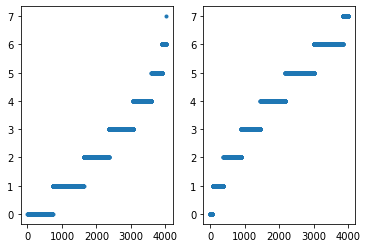

In [15]:
plt.subplot(1,2,1)
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.subplot(1,2,2)
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')

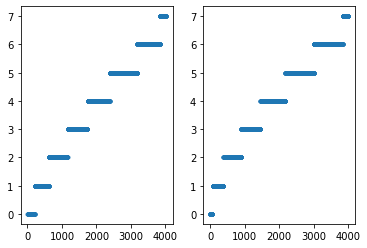

In [17]:
plt.subplot(1,2,1)
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.subplot(1,2,2)
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')

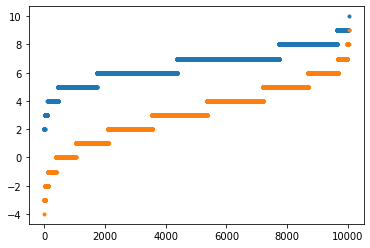

In [10]:

plt.plot(sorted(np.floor(np.divide(r_ej_list,0.1))), '.')
plt.plot(sorted(np.floor(np.divide(h_ej_list,0.1))), '.')

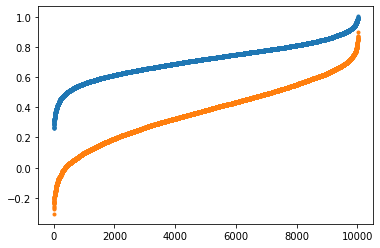

In [14]:

plt.plot(sorted(r_ej_list), '.')
plt.plot(sorted(h_ej_list), '.')

In [17]:
np.max(r_ej_list)

1.0029073323322029

In [16]:
1.0 - 0.2

0.8

In [25]:
np.min((np.array(r_ej_list)-0.2))

0.06430966249940168

In [23]:
np.min(np.floor((np.array(r_ej_list)-0.2)/0.05).astype(np.int))

1

In [9]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [13]:
x = div_r_gaussian(sorted(r_ej_list)[5000])

In [14]:
y = div_h_gaussian(sorted(h_ej_list)[5000])

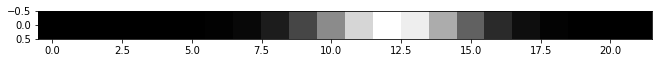

In [28]:
plt.figure(figsize=(11,5))
plt.imshow(x[np.newaxis, :], cmap='gray')

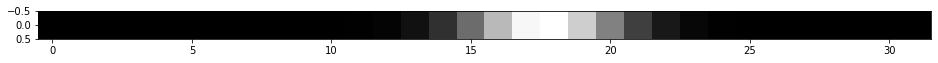

In [29]:
plt.figure(figsize=(16,5))
plt.imshow(y[np.newaxis, :], cmap='gray')

In [63]:
def div_h_gaussian(h_val):
    return gaussian(h_val, np.arange(-0.5,1.1, 0.05),0.05)

In [53]:

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-4.5)*8)

In [60]:
X = np.repeat(np.transpose([div_r_gaussian(r_val) for r_val in sorted(r_ej_list)]), 100, axis=0)

In [64]:
X = np.repeat(np.transpose([div_h_gaussian(h_val) for h_val in sorted(h_ej_list)]), 100, axis=0)

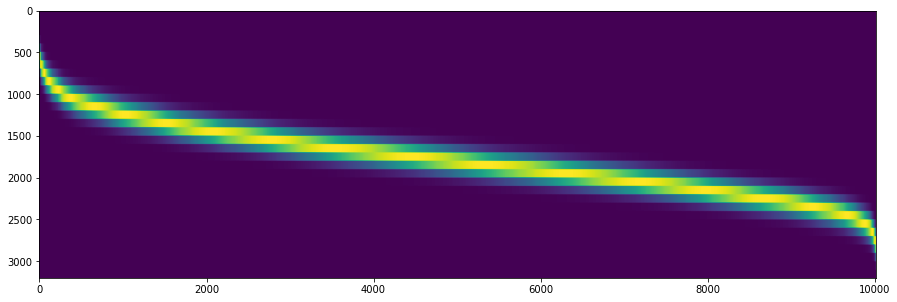

In [65]:
plt.figure(figsize=(15,15))
plt.imshow(X)

In [50]:
min(r_ej_list), max(r_ej_list)

(0.2643096624994017, 1.0029073323322029)

In [62]:
min(h_ej_list), max(h_ej_list)

(-0.3061460527588161, 0.9013190441174193)

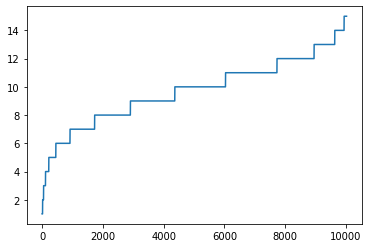

In [8]:
plt.plot(sorted(np.clip(np.floor((np.array(r_ej_list)-0.2)/0.05).astype(np.int), 0, 15)))

In [32]:
Ndat = len(data_pairs_train)
sorted(r_ej_list)

[0.2643096624994017,
 0.2654511355660337,
 0.26557373530205847,
 0.26736146074794437,
 0.2709307666720339,
 0.2800006293030438,
 0.28259406377991036,
 0.28790997323564255,
 0.28954171998890366,
 0.29020267004998007,
 0.29040935644979476,
 0.2941679210366596,
 0.2942319968245062,
 0.3003554180727851,
 0.3057012871216988,
 0.3066618108545819,
 0.3075435346332892,
 0.3102567908219746,
 0.3144900502304323,
 0.3149769810362106,
 0.3156346084741473,
 0.3162066318597787,
 0.3180800574497773,
 0.31980564672267164,
 0.3230705844137329,
 0.323242529440996,
 0.32465085269731625,
 0.3247219116383958,
 0.32520612447338204,
 0.32829309531918227,
 0.33127686305424753,
 0.33159413954333106,
 0.3333565662591931,
 0.33427156464492463,
 0.33504485538732587,
 0.33506121614245343,
 0.33673019702899565,
 0.3382773824607096,
 0.33935135583589215,
 0.3428806682373158,
 0.3431358003240094,
 0.3448717054194184,
 0.34526442223832776,
 0.3457277650011509,
 0.3495098494630322,
 0.3504850996751348,
 0.3505980788504